# Exploring the LSTM model's similarity space

In order to find out more about the model's capabilities, we visualise the similarity space and in particular plot the relative location of accent contours that are classified correctly (or incorrectly) as either Accent 1 or 2. 


In [1]:
import os,re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


import sklearn
import keras
from tensorflow.keras.utils import to_categorical



We load the trained model with the best training/test performance.

In [2]:
model3 = keras.models.load_model('Models/m20220914-215926_3')

2022-10-15 16:23:04.956137: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In addition to the speech contour corpus itself, we also load a set of "prototype" items. These are pitch contours extracted from recordings made for a psycholinguistic study, from isolated single-word utterances, and therefore correspond closely to the prototypical accent patterns. These recordings have been preprocessed in the same way as the NST corpus.

In [3]:
Corpus=pd.read_csv('PitchData.csv', encoding="UTF-8")
Prototypes=pd.read_csv('PreppedPrototypes.csv')


In [4]:
X=Corpus.iloc[:,11:Corpus.shape[1]].to_numpy()
Corpus['Acc']=Corpus['Acc'].map({'[1, 0]':1, '[2, 0]':2})
Y=Corpus['Acc'].to_numpy()

In [5]:
scols=[cname for cname in Prototypes.columns if cname.startswith('S')]
prototypes=Prototypes[scols].to_numpy()
label_proto=(Prototypes['Acc']).to_numpy()

In [6]:
NewX=np.concatenate([X,prototypes],axis=0)
print(NewX.shape)
NewY=np.concatenate([Y,label_proto],axis=0)
print(NewY.shape)


(19218, 100)
(19218,)


In [7]:
def prediction_accuracy(m, X,Y):
    #returns 
    #Accuracy:  correct items / total items
    #Pred: predicted category label
    #Corr: binary list, 0-incorrect, 1-correct
    pred = m.predict(X)

    CatPred=[]
    idx=0
    Corr=[]
    for p in pred:
    
        cat=np.argmax(p)+1
        CatPred.append(cat)
    
        if cat==Y[idx]:#adapt these
            Corr.append(1)
        else:
            Corr.append(0)
        
        idx=idx+1
    print('Accuracy:'+str(round(sum(Corr)/len(Y),2)))
    #print('N incorr:'+str(len(Y)-sum(Corr)))
    return sum(Corr)/len(Y), CatPred, Corr


[Accuracy, Pred, Corr]=prediction_accuracy(model3, NewX, NewY)

Accuracy:0.8


In [8]:

NewXLabels=pd.DataFrame({'TrueLabel':NewY,'PredLabel':Pred,'Corr':Corr})
nstlabel=['nst']*X.shape[0]
protolabel=['proto']*prototypes.shape[0]
NewXLabels['Corpus']=nstlabel+protolabel


Having concatenated the original corpus and prototypes and obtained model predictions for all these items (overall accuracy 80%), we can now run these patterns through the model and obtain hidden unit activations for each of them.

In [9]:
from tensorflow.keras.layers import Input, Dense, LSTM, Activation, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
def create_truncated_model(input_shape,trained_model):
    pitch_vals=Input(shape=input_shape, dtype='float32')
    X=LSTM(120, return_sequences=False)(pitch_vals)
    
    model = Model(inputs=pitch_vals, outputs=X)
    
    for i, layer in enumerate(model.layers):
        layer.set_weights(trained_model.layers[i].get_weights())
    model.compile(optimizer=SGD(lr=0.05),
              loss='categorical_crossentropy')
    return model

truncated_model = create_truncated_model((100,1),model3)


/opt/anaconda3/envs/sweDL/lib/python3.10/site-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [10]:
hidden_features = truncated_model.predict(NewX)

In order to visualise the hidden unit activations we use a combination of PCA (reduction to 20 dimensions from 120), and t-sne (reduction to 2 dimensions). This 2-dimensional projection of the similarity space can then be visualised easily.

In [11]:

from sklearn.decomposition import PCA

pca = PCA(n_components=20)
pca_result = pca.fit_transform(hidden_features)

In [12]:
from sklearn.manifold import TSNE

tsne=TSNE(n_components=2, verbose=1)
tsne_results_all=tsne.fit_transform(pca_result)

/opt/anaconda3/envs/sweDL/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/anaconda3/envs/sweDL/lib/python3.10/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 19218 samples in 0.001s...
[t-SNE] Computed neighbors for 19218 samples in 8.275s...
[t-SNE] Computed conditional probabilities for sample 1000 / 19218
[t-SNE] Computed conditional probabilities for sample 2000 / 19218
[t-SNE] Computed conditional probabilities for sample 3000 / 19218
[t-SNE] Computed conditional probabilities for sample 4000 / 19218
[t-SNE] Computed conditional probabilities for sample 5000 / 19218
[t-SNE] Computed conditional probabilities for sample 6000 / 19218
[t-SNE] Computed conditional probabilities for sample 7000 / 19218
[t-SNE] Computed conditional probabilities for sample 8000 / 19218
[t-SNE] Computed conditional probabilities for sample 9000 / 19218
[t-SNE] Computed conditional probabilities for sample 10000 / 19218
[t-SNE] Computed conditional probabilities for sample 11000 / 19218
[t-SNE] Computed conditional probabilities for sample 12000 / 19218
[t-SNE] Computed conditional probabilities for sam

In [24]:
conditions = [
    ((NewXLabels['TrueLabel']==1) & (NewXLabels['Corr']==1) & (NewXLabels['Corpus']=='nst')),
    ((NewXLabels['TrueLabel']==1) & (NewXLabels['Corr']==0)& (NewXLabels['Corpus']=='nst')),
    ((NewXLabels['TrueLabel']==2) & (NewXLabels['Corr']==1)& (NewXLabels['Corpus']=='nst')),
    ((NewXLabels['TrueLabel']==2) & (NewXLabels['Corr']==0)& (NewXLabels['Corpus']=='nst')),
    ((NewXLabels['TrueLabel']==1) & (NewXLabels['Corr']==1) & (NewXLabels['Corpus']=='proto')),
    ((NewXLabels['TrueLabel']==1) & (NewXLabels['Corr']==0)& (NewXLabels['Corpus']=='proto')),
    ((NewXLabels['TrueLabel']==2) & (NewXLabels['Corr']==1)& (NewXLabels['Corpus']=='proto')),
    ((NewXLabels['TrueLabel']==2) & (NewXLabels['Corr']==0)& (NewXLabels['Corpus']=='proto')),

]

vals=[0,1,2,3,4,5,6,7]
    
TSNELabels=np.select(conditions,vals)



In [52]:
#tsneDF=pd.DataFrame({'tsne1':tsne_results_all[:,0], 'tsne2':tsne_results_all[:,1],'label':TSNELabels})
#tsneDF.to_csv('tsne.csv')

We can now plot the similarity space for items falling into different categories -- correct/incorrect Accent1 and correct/incorrect Accent 2 items. For comparison we plot the prototype patterns in a different colour.

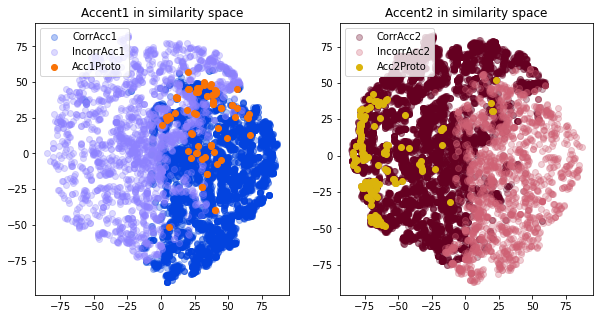

In [49]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,5))

cm=['xkcd:blue', 'xkcd:periwinkle', 'xkcd:maroon','xkcd:rose', 'xkcd:orange','xkcd:aqua', 'xkcd:gold','xkcd:aqua']
for cl in [0,1,4]:
    indices=np.where(TSNELabels==cl)
    if cl in [0,1]:
        axes[0].scatter(tsne_results_all[indices,0], tsne_results_all[indices,1], c=cm[cl],label=cl, alpha=.3)
    else:
        axes[0].scatter(tsne_results_all[indices,0], tsne_results_all[indices,1], c=cm[cl],label=cl)
    axes[0].legend(['CorrAcc1','IncorrAcc1','Acc1Proto'], loc='upper left')
    axes[0].title.set_text('Accent1 in similarity space')
    
for cl in [2,3,6]:
    indices=np.where(TSNELabels==cl)
    if cl in [2,3]:
        axes[1].scatter(tsne_results_all[indices,0], tsne_results_all[indices,1], c=cm[cl],label=cl, alpha=.3)
    else:
        axes[1].scatter(tsne_results_all[indices,0], tsne_results_all[indices,1], c=cm[cl],label=cl)
    axes[1].legend(['CorrAcc2','IncorrAcc2','Acc2Proto'], loc='upper left')
    axes[1].title.set_text('Accent2 in similarity space')



Broadly these plots show that correct Accent 1 patterns cluster in the right half of the similarity space, correct Accent 2 patterns cluster in the left half and at the top. However, incorrectly classified patterns occur all over the similarity space, they don't just cluster around the edges of the 'correct' area for that accent pattern. In other words, while statistically 80% of all recordings had a contour that clusters with the rest of the pattern in that grammatical class, 20% were uttered with a contour that sounds more like 'the other type of accent'.

The prototype recordings from each class cluster mainly in a small area within the total area taken up by 'correct' items from the corpus. This demonstrates that the contours found in the corpus are more varied and don't all correspond to the 'prototypical' accent patterns. But it also shows that the LSTM model still learned to discriminate between these more variable patterns in a reliable way. 

Accent 2 prototypes cluster around the left edge, i.e. in a part of the similarity space that is occupied by correct Accent 2 patterns and incorrect Accent 1 patterns. This shows that although Accent 2 has the more complex prosodic 2-peak pattern, speakers sometimes produce a pattern that grammatically ought to be Accent 1 with this Accent 2 contour. 

By contrast a large number of Accent 1 prototypes cluster in an area that has both correct and incorrect Accent 1 patterns (and correct and incorrect Accent 2 patterns). In other words, in this area of the similarity space there is very little certainty. It apppears that the 'prototypical' 1-peak Accent 1 pattern is actually quite unspecific, so that both Accent 1 and Accent 2 patterns occur with this contour.

# Is the model sensitive to the number of peaks?

Because we know that the 'prototypical' shapes of the two accent patterns are a single peak vs. two peaks, we can generate some patterns using sine waves, systematically change the location of the peak(s), and then pass these through the model in order to get a better understanding of how the model classifies the patterns. Here are two examples of a single and a two-peak pattern:

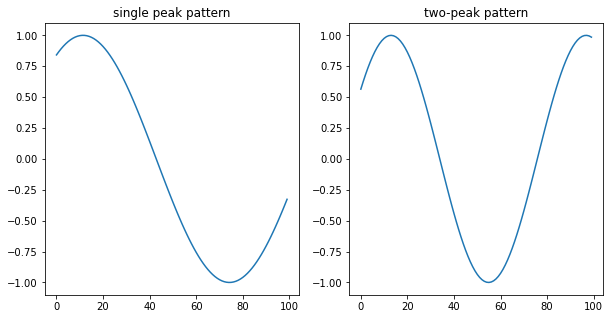

In [9]:
fig,axes=plt.subplots(1, 2, sharex=True, figsize=(10,5))

x=list(range(100))
y=[np.sin(0.05*(i+20)) for i in x]

axes[0].plot(x,y)
axes[0].title.set_text('single peak pattern')

y2=[np.sin(0.075*(i+8)) for i in x]
axes[1].plot(x,y2)
axes[1].title.set_text('two-peak pattern')

plt.show()

Now we can test systematically for what range of the phase parameters the model recognises the patterns as Acc1 or Acc2 (we run this for parameters in a range that will produce patterns that are at the right point in the phase):

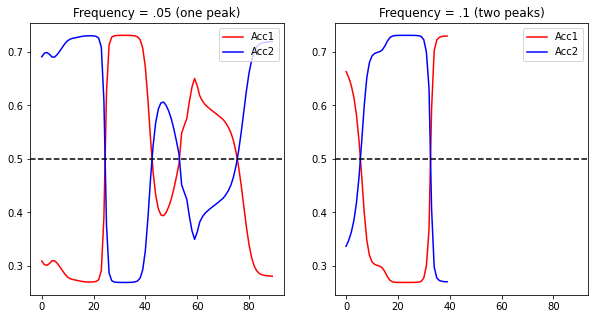

In [10]:
x=list(range(100))
sim_predictions1=[]
sim_predictions2=[]
for a in range(-60,30):
    y=[np.sin(0.05*(i+a)) for i in x]

    y_=np.array(y)
    y_=np.expand_dims(y_, axis=0)
    p=model3.predict(y_)
    sim_predictions1.append(p[0][0])
    sim_predictions2.append(p[0][1])


fig,axes=plt.subplots(1, 2, sharex=True, figsize=(10,5))
axes[0].plot(sim_predictions1,color='red')
axes[0].plot(sim_predictions2,color='blue')
axes[0].legend(['Acc1','Acc2'],loc='upper right')
axes[0].axhline(.5,color='black',linestyle='--')
axes[0].title.set_text('Frequency = .05 (one peak)')

sim_predictions1=[]
sim_predictions2=[]
for a in range(-25,15):
    y=[np.sin(0.075*(i+a)) for i in x]
#fig=plt.figure()
#plt.plot(x,y)
#plt.show()
    y_=np.array(y)
    y_=np.expand_dims(y_, axis=0)
    p=model3.predict(y_)
    sim_predictions1.append(p[0][0])
    sim_predictions2.append(p[0][1])

axes[1].plot(sim_predictions1,color='red')
axes[1].plot(sim_predictions2,color='blue')
axes[1].legend(['Acc1','Acc2'],loc='upper right')
axes[1].axhline(.5,color='black',linestyle='--')
axes[1].title.set_text('Frequency = .1 (two peaks)')



plt.show()


For one-peak patterns the results are more mixed, i.e. whether the item is classified as Acc1 or 2 depends on timing.
For the two-peak patterns by contrast the model amost exclusively returns an Accent 2 output. This is in line with the idea that Accent 1 is a less distinctive pattern. 

# Which part of the signal contributes to classification?

Human listeners can correctly distinguish between forms like 'buller' ('noise', Acc1) and 'bulle' ('bun', Acc2) after hearing just the first syllable 'bul-', i.e. at a time when only the pitch pattern differentiates the words. Can the model do this too? 

In the set of input patterns, we can systematically replace parts of the signal by the overall mean pitch for the relevant time slot in order to test how model accuracy degrades.

We incrementally (10 segments per step) replace segments (a) beginning at the left edge and (b) beginning at the right edge, and log classification accuracy.

In [11]:
M=np.mean(X,axis=0)
step=10
cutsize=10
cuts=[cutsize+step*i for i in range(10)]
mx=100
RLAccuracy=[]
for c in cuts:
    print('replaced '+str(c)+ ' segments from right edge')
    Xcut=X[:,0:mx-c]
    fill=np.reshape(list(M[mx-c:mx])*X.shape[0],(X.shape[0],c))
    Xfilled=np.concatenate([Xcut,fill], axis=1)
    
    [Acc, Pred, Corr]=prediction_accuracy(model3, Xfilled, Y)
    RLAccuracy.append(Acc)

replaced 10 segments from right edge
Accuracy:0.76
replaced 20 segments from right edge
Accuracy:0.73
replaced 30 segments from right edge
Accuracy:0.72
replaced 40 segments from right edge
Accuracy:0.69
replaced 50 segments from right edge
Accuracy:0.63
replaced 60 segments from right edge
Accuracy:0.59
replaced 70 segments from right edge
Accuracy:0.56
replaced 80 segments from right edge
Accuracy:0.56
replaced 90 segments from right edge
Accuracy:0.45
replaced 100 segments from right edge
Accuracy:0.43


In [13]:
step=10
cutsize=10
cuts=[cutsize+step*i for i in range(10)]
mx=100
LRAccuracy=[]
for c in cuts:
    print('replaced '+str(c)+ ' segments from left edge')
    Xcut=X[:,c:mx]
    fill=np.reshape(list(M[0:c])*X.shape[0],(X.shape[0],c))
    Xfilled=np.concatenate([fill, Xcut], axis=1)
    
    [Acc, Pred, Corr]=prediction_accuracy(model3, Xfilled, Y)
    LRAccuracy.append(Acc)

replaced 10 segments from left edge
Accuracy:0.71
replaced 20 segments from left edge
Accuracy:0.66
replaced 30 segments from left edge
Accuracy:0.6
replaced 40 segments from left edge
Accuracy:0.51
replaced 50 segments from left edge
Accuracy:0.47
replaced 60 segments from left edge
Accuracy:0.48
replaced 70 segments from left edge
Accuracy:0.46
replaced 80 segments from left edge
Accuracy:0.43
replaced 90 segments from left edge
Accuracy:0.43
replaced 100 segments from left edge
Accuracy:0.43


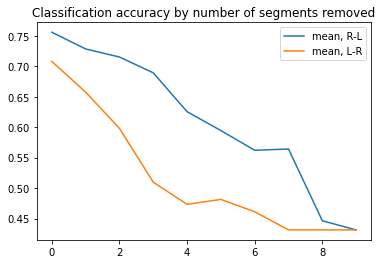

In [14]:
plt.figure()
plt.plot(RLAccuracy, label="mean, R-L")
b=plt.plot(LRAccuracy, label="mean, L-R")
plt.legend()
plt.title('Classification accuracy by number of segments removed')
plt.show()

As this plot shows, accuracy falls off more steeply when replacing segments from the left edge compared to the right edge, suggesting that the first part of the pitch pattern is more relevant to classification.


# Conclusions

The model has learned to separate Accent 1 and Accent 2 patterns successfully, despite pitch contours in the NST corpus being much more variable than prototypical exemplars. Of note is that the LSTM network was trained with *grammatical* labels as teaching signal, i.e. the model had to deal with potentially mispronounced items.

Classification errors are distributed across the entire similarity space, implying that speakers routinely pronounce Accent 1 and Accent 2 words with pitch contours that are less easily classified and may indeed be more similar to patterns in the other class. A closer investigation of this is warranted.

In terms of how the network achieves its classification, there are two observations: (a) the network seems to be broadly sensitive to the number of peaks in the signal, and (b) the earlier segments seem to be more important for the classification. Both of these aspects are consistent with what we know from linguistic analysis. We can conclude that analysing pitch patterns with LSTM neural networks is a valid approach.